In [1]:
mlf_chars = ['ex', 'qu', 'ga', 'do', 'am', 'ti', 'sl', 'lb', 'rb', 'ls', 'rs', 'sr', 'cm', 'mi',
                 'pl', 'pt', 'sp', 'cl', 'sc', 'qm', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7',
                 'n8', 'n9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
                 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
                 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                 'y', 'z']

CHARS = ['!', '"', '', '', '&', "'", '/', '(', ')', '[', ']', '*', ',', '-',
             '+', '.', ' ', ':', ';', '?', '0', '1', '2', '3', '4', '5', '6', '7',
             '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
             'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
             'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
             'y', 'z', '%']

blank_index = len(mlf_chars)
non_alphabets = ['!', '"', '', '', '&', "'", '/', '(', ')', '[', ']', '*', ',', '-',
                  '+', '.', ' ', ':', ';', '?', '0', '1', '2', '3', '4', '5', '6', '7',
                 '8', '9', ]

CHARS_SIZE = len(mlf_chars) + 1

blacklists=["h02-037-02", "a02-062-01","a02-062-02","a02-062-03","e05-265z-04",'g04-060-02','j06-278z-04','h04-141z-03']

In [2]:
from nltk.util import ngrams
import io

def update_counter(counter, ngram, fname, batch=8):
    print("Updating counter with file:")
    print(fname)
    with io.open(fname, encoding='utf8') as fin:
        txt = fin.read()
        txt = clean_text(txt)
    # n of batches
    k = int(len(txt) / batch)

    # for each ngram
    print("Updating ngrams:")
    for n in tqdm(range(1, ngram + 1)):
        # for each batch
        for i in range(k + 1):
            # update ngram
            start = 0 if i == 0 else i * batch - n + 1
            last = -1 if i == k else (i + 1) * batch + n - 1
            counter.update([ngrams(txt[start:last], n)])
    return counter

def clean_space(txt):
    return re.sub(r"\s+", " ", txt)


def clean_newline(txt):
    return re.sub(r"\n", " ", txt)


def clean_chars(txt):
    return re.sub(r"[^!\"&'/\(\)\[\]*,\-+.\s:;?0-9a-zA-Z]", "", txt)


def clean_text(txt):
    return clean_space(clean_newline(clean_chars(txt))).lower()

In [3]:
#ngram = 7
#filename = "lm_7gram_counter.pkl"
#
#counter = NgramCounter()
#for p in range(1, 6):
#    filenumber = "0000" + str(p)
#    print(filenumber)
#    fn = './ngram/news.en-' + filenumber + '-of-00100'
#    counter = update_counter(counter, ngram, fn)
#
#with open(filename, 'wb') as fout:
#    pickle.dump(counter, fout)

In [4]:
class ReadFile():
    def __init__(self,mode=None):
        self.mode = mode
    def get_samples(self):
        if(self.mode=='train'):
            file = open("./data/online/iam-config/trainset.txt")
        elif(self.mode=="valid"):
            file = open("./data/online/iam-config/testset_v.txt")
        elif(self.mode=="eval"):
            file = open("./data/online/iam-config/testset_f.txt")
            
        sample_names = []
        names = ''
        i = 0
        for n in file:
            names =  n.strip(' \n')
            sample_names += [names]
        
        file = open("./data/online/iam-config/t2_labels.mlf")
        samples = []
        current_groundtruth = []
        current_path = ""
        current_sample_name = ""
        
        for n in file:   
            if("scratch" in n):    
                if current_path and current_sample_name in sample_names:
                    current_groundtruth = current_groundtruth[:-1]
                    samples.append(Each_Sample(current_path, current_groundtruth))
                
                current_groundtruth = []
                current_path = ""
                current_sample_name = ""
                scratch = n.strip(' "\n').split('/')
                file_name = scratch[8].split('.')[0]
    
                if(file_name in blacklists):
                    continue
    
                split_name = file_name.split('-')
                file_name = split_name[0] + "/" + split_name[0] + "-" + split_name[1][:3] + "/" + file_name + ".xml"
                current_path = "./data/online/iam/" + file_name
                current_sample_name = split_name[0] + "-" + split_name[1]
                             
            elif("#" in n):
                continue
            else:
                current_groundtruth.append(n.strip('\n'))
        return samples

In [5]:
class Each_Sample(object):
    def __init__(self, xml_path, ground_truth):
        self.xml_path = xml_path
        self.ground_truth = ground_truth
        
    def get_groundtruth_text(self):
        gt =''
        for i in range(len(self.ground_truth)):
            char = self.ground_truth[i]
            index = mlf_chars.index(char)
            gt += CHARS[index]
        return gt
    
    def generate_pointSet(self):
        xml = open(self.xml_path, 'rb').read()
        root = etree.XML(xml)
        wbd, strokeset = root.getchildren()

        sensorlocation = wbd[0].attrib['corner']
        diagonalX = wbd[1].attrib['x']
        diagonalY = wbd[1].attrib['y']
        verticalX = wbd[2].attrib['x']
        verticalY = wbd[2].attrib['y']
        horizontalX = wbd[3].attrib['x']
        horizontalY = wbd[3].attrib['y']

        strokes = []
        stroke_id = 1
        min_time = Decimal(strokeset.getchildren()[0].getchildren()[0].attrib['time'])
        for stroke in strokeset:
            for point in stroke:
                t = (Decimal(point.attrib['time']) - min_time) * 1000
                x = point.attrib['x']
                y = point.attrib['y']
                strokes.append([stroke_id, t, x, y])
            stroke_id += 1
        strokes = np.asarray(strokes, dtype=np.int64)

        right = int(diagonalX)
        bottom = int(diagonalY)  # right, bottom edge
        left = int(verticalX) # left edge
        upper = int(horizontalY)  # upper edge

        strokes[:, 2] = np.subtract(strokes[:, 2], left)
        strokes[:, 3] = np.subtract(strokes[:, 3], upper)
        points = []
        for s in strokes:
            points.append(Point(*s))
        return Each_Sample_PointSet(points=points)
    
    
    def generate_child_pointSet(self):
        df = pd.read_csv(self.xml_path)
        x = df['X'].tolist()
        y = df['Y'].tolist()
     
        dottype = df['DotType'].tolist()
        time = df['Timestamp'].tolist()
        t = []
        t.append(0)
        for i in range(1,len(time)):
            t.append(time[i]-time[i-1])
            
        s = 1
        count = 0
        strokes = []
        for i in range(len(dottype)):
            if(dottype[i]=="PEN_UP"):
                count += 1
                strokes.append(s)
                s +=1
            else:
                strokes.append(s)
        
        for i in range(len(x)):
            x1 = x[i]*100
            y1 = y[i]*100
            x[i] = x1
            y[i] = y1
        
        points = []
        for i in range(len(x)):
            points.append(Point(strokes[i],t[i],x[i],y[i]))
        return Each_Sample_PointSet(points=points,gt=self.get_groundtruth_text())
            
    def __repr__(self):
        return str(self.xml_path.split("/")[-1][:-4])

In [6]:
import os
from lxml import etree
from decimal import Decimal
import numpy as np
from pylab import rcParams
from matplotlib import pyplot as plt
from rdp import rdp

In [7]:
class Each_Sample_PointSet:
    def __init__(self, points=None, gt=None):
        self.points = points 
        self.gt = gt
    
    def get_strokegroup(self):
        strokes = []
        for i in range(len(self.points)):
            p = self.points[i]
            strokes.append(p.stroke)
        
        temp_sg = []
        stroke_groups = []

        strokes = set(strokes)
        strokes = list(strokes)
        
        for i in range(len(strokes)):
            n = strokes[i]
            for j in range(len(self.points)):
                p = self.points[j]
                if(p.stroke==n):
                    temp_sg.append(p)
            stroke_groups.append(temp_sg)
            temp_sg = []    
        return stroke_groups
    
    def generate_strokegroup_lines(self):
        lines = []
        strokes = self.get_strokegroup()
        for st in range (len(strokes)):
            s = strokes[st]
            for i in range(len(s) - 1):
                if i == len(s) - 2:
                    lines.append(Line(s[-2], s[-1], eos=True))
                else:
                    lines.append(Line(s[i], s[i + 1]))
        return lines
  
    def preprocessing(self):
        
        y_sd = []
        x_sd = []
        for i in range(len(self.points)):
            p = self.points[i]
            x_sd.append(p.x)
            y_sd.append(p.y)
        
        x_sd = np.array(x_sd)
        y_sd = np.array(y_sd)
        
        x_mean = np.mean(x_sd)
        y_mean = np.mean(y_sd)

        sd_x = np.std(x_sd)
        sd_y = np.std(y_sd)
     
        for p in range (len(self.points)):
            point = self.points[p]
            point.x = (point.x - x_mean)/sd_y
            point.y = (point.y - y_mean)/ sd_y
            self.points[p] = point
            
        x = []
        y = []
        l = []
        for i in range(len(self.points)):
            p = self.points[i]
            new_p = [p.x,p.y]
            l.append(new_p)
       # print(l)
        
        x_new = []
        y_new = []
        new_l = rdp(l,epsilon=0.03)
        for i in range(len(new_l)):
            x_new.append(new_l[i][0])
            y_new.append(new_l[i][1])
            
        new_p = []
        for i in range(len(self.points)):
            x = self.points[i].x
            if x in x_new:
                new_p.append(self.points[i])
            
        self.points = new_p
        self.linear_interpolation(d=0.15)
        
    def preprocessing_children(self):
        
        y_sd = []
        x_sd = []
        for i in range(len(self.points)):
            p = self.points[i]
            x_sd.append(p.x)
            y_sd.append(p.y)
        
        x_sd = np.array(x_sd)
        y_sd = np.array(y_sd)
        
        x_mean = np.mean(x_sd)
        y_mean = np.mean(y_sd)

        sd_x = np.std(x_sd)
        sd_y = np.std(y_sd)
     
        for p in range (len(self.points)):
            point = self.points[p]
            point.x = (point.x - x_mean)/sd_y
            point.y = (point.y - y_mean)/ sd_y
            self.points[p] = point
            
        x = []
        y = []
        l = []
        for i in range(len(self.points)):
            p = self.points[i]
            new_p = [p.x,p.y]
            l.append(new_p)
       # print(l)
        
        x_new = []
        y_new = []
        new_l = rdp(l,epsilon=0.03)
        for i in range(len(new_l)):
            x_new.append(new_l[i][0])
            y_new.append(new_l[i][1])
            
        new_p = []
        for i in range(len(self.points)):
            x = self.points[i].x
            if x in x_new:
                new_p.append(self.points[i])
            
        self.points = new_p
        self.linear_interpolation(d=0.05)
        
   
    def linear_interpolation(self, d):
        strokes = self.get_strokegroup()
        interp_points = []
        for s in range(len(strokes)):
            stroke = strokes[s]
            if len(stroke) > 0:
                interp_points.append(stroke[0])
            for i in range(1, len(stroke)):
                line = Line(interp_points[-1], stroke[i])
                l = line.length()
                
                if l > d:
                    f = d / l
                    iteration = int(l / d)
                    for j in range(iteration):
                        iterated = f*(j+1)
                        p1 = line.p1
                        p2 = line.p2
                        time_diff = p2.time - p1.time
                        
                        new_vec = line.vec()*iterated
                        new_time_diff = time_diff*iterated
                        new_coord = p1.coordinates() + new_vec
                        new_x = new_coord[0]
                        new_y = new_coord[1]
                        
                        point = Point(p1.stroke,p1.time+new_time_diff,new_x,new_y)
                        interp_points.append(point)

                elif l == d:
                    interp_points.append(stroke[i])
                elif l < d:
                    continue
            interp_points.append(stroke[-1])
        self.points = interp_points
        return interp_points
    
    def generate_features(self):
        self.preprocessing()
        lines = self.generate_strokegroup_lines()
        features = []
        
        for i in range(len(lines)):
            l = lines[i]
            f = l.get_features()
            features.append(f)
        features = np.array(features) 
        
        dim = features.shape[0]
        result = np.zeros((dim, features.shape[1]))
        result[:features.shape[0], :] = features
        return result
    
    def generate_children_features(self):
        self.preprocessing_children()
        lines = self.generate_strokegroup_lines()
        features = []
        
        for i in range(len(lines)):
            l = lines[i]
            f = l.get_features()
            features.append(f)
        features = np.array(features) 
        
        dim = features.shape[0]
        result = np.zeros((dim, features.shape[1]))
        result[:features.shape[0], :] = features
        return result
  
    def plot(self):
        rcParams['figure.figsize'] = 10, 20
        groups = self.get_strokegroup()
        x = []
        y = []
       
        for i in range(len(groups)):
            g = groups[i]
            for j in range(len(g)):
                x.append(g[j].x)
                y.append(-g[j].y)
                
            plt.plot(x, y, '.', linewidth=2, color=(0, 0, 0))
            x=[]
            y=[]
    
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        
    def plot_children(self):
        rcParams['figure.figsize'] = 2, 2
        groups = self.get_strokegroup()
        x = []
        y = []
       
        for i in range(len(groups)):
            g = groups[i]
            for j in range(len(g)):
                x.append(g[j].x)
                y.append(-g[j].y)
                
            plt.plot(x, y, '.', linewidth=2, color=(0, 0, 0))
            x=[]
            y=[]
        gt = self.gt
        plt.gca().set_aspect(aspect=0.9)
        plt.axis('off')
        plt.savefig('./data/png/' + gt + ".png", bbox_inches='tight',pad_inches = 0)
        plt.show()
        plt.close()
        
    def __repr__(self):
        return str("PointSet: " + str(len(self.points)) + " points")

In [8]:
class Point:

    def __init__(self, stroke, time, x, y):
        self.stroke = stroke
        self.time = time
        self.x = x
        self.y = y

    def coordinates(self):
        return np.array([self.x, self.y])

    def __repr__(self):
        return str("Point stroke=" + str(self.stroke) + " time=" + str(self.time) + " x=" + str(self.x) + " y=" + str(self.y))

In [9]:
class Line:
    def __init__(self, p1, p2, eos=False):
        self.p1 = p1
        self.p2 = p2
        self.eos = eos

    def vec(self):
        return self.p2.coordinates() - self.p1.coordinates()

    def length(self):
        return np.linalg.norm(self.vec())

    def get_features(self):
        x_start = self.p1.x
        y_start = self.p1.y
        delta_x, delta_y = self.vec()
        if(self.eos==False):
            down = 1
            up = 0
        elif(self.eos==True):
            down = 0
            up = 1
        
        time_diff = self.p2.time - self.p1.time
        return np.array([x_start, y_start, delta_x, delta_y, down, up])

    def __repr__(self):
        return str("Line" + self.p1.__repr__() + '\n' + self.p2.__repr__() + '\n>')

In [12]:
train = ReadFile("train")
train_samples = train.get_samples()
train_samples[0]

a01-001w-01

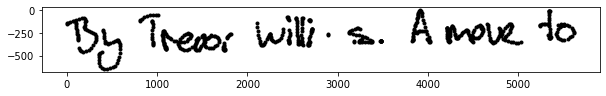

[Point stroke=1 time=0 x=75 y=116,
 Point stroke=1 time=20 x=95 y=137,
 Point stroke=1 time=30 x=95 y=148,
 Point stroke=1 time=40 x=97 y=169,
 Point stroke=1 time=60 x=101 y=193,
 Point stroke=1 time=80 x=106 y=217,
 Point stroke=1 time=90 x=111 y=241,
 Point stroke=1 time=100 x=116 y=261,
 Point stroke=1 time=120 x=118 y=277,
 Point stroke=1 time=130 x=123 y=293,
 Point stroke=1 time=150 x=126 y=309,
 Point stroke=1 time=160 x=123 y=317,
 Point stroke=1 time=180 x=126 y=329,
 Point stroke=2 time=450 x=5 y=150,
 Point stroke=2 time=470 x=0 y=145,
 Point stroke=2 time=480 x=8 y=139,
 Point stroke=2 time=500 x=34 y=129,
 Point stroke=2 time=510 x=63 y=115,
 Point stroke=2 time=530 x=95 y=101,
 Point stroke=2 time=540 x=134 y=94,
 Point stroke=2 time=560 x=164 y=84,
 Point stroke=2 time=570 x=189 y=87,
 Point stroke=2 time=590 x=202 y=94,
 Point stroke=2 time=600 x=212 y=113,
 Point stroke=2 time=620 x=205 y=133,
 Point stroke=2 time=630 x=196 y=159,
 Point stroke=2 time=640 x=190 y=179,

In [13]:
train_pts = train_samples[0].generate_pointSet()
train_pts.plot()
train_pts.points

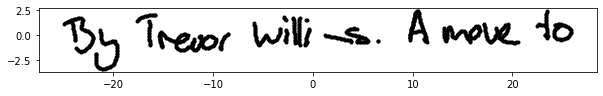

In [14]:
train_pts.preprocessing()
train_pts.plot()

In [15]:
train = ReadFile("train").get_samples()
valid = ReadFile("valid").get_samples()
evaluation = ReadFile("eval").get_samples()

In [16]:
def save_feature_npz():
    train_samples = ReadFile("train").get_samples()
    valid_samples = ReadFile("valid").get_samples()
    evaluation_samples = ReadFile("eval").get_samples()
#  
    bad_samples = []
    for i in range(len(train_samples)):
        if(i%200==0):
            print(i)
        sample = train_samples[i]
        xml_path = sample.xml_path
        labels = sample.ground_truth
        f_split = xml_path.split('/')
        f_split[-4] = 'npz-train'
        f_split[-1] = f_split[-1][:-3] + 'npz'
        f = '/'.join(f_split)
        pointsets = sample.generate_pointSet()
        features = pointsets.generate_features()
        d = '/'.join(f_split[:-1])
         
        if not os.path.exists(d):
            os.makedirs(d)
        np.savez(f, x=features, y=labels)
        
    bad_samples = []
    for i in range(len(valid_samples)):
        if(i%200==0):
            print(i)
        sample = valid_samples[i]
        xml_path = sample.xml_path
        labels = sample.ground_truth
        f_split = xml_path.split('/')
        f_split[-4] = 'npz-valid'
        f_split[-1] = f_split[-1][:-3] + 'npz'
        f = '/'.join(f_split)
        pointsets = sample.generate_pointSet()
        features = pointsets.generate_features()
        d = '/'.join(f_split[:-1])
        
        if not os.path.exists(d):
            os.makedirs(d)
        np.savez(f, x=features, y=labels)
        
    bad_samples = []
    for i in range(len(evaluation_samples)):
        if(i%200==0):
            print(i)
        sample = evaluation_samples[i]
        xml_path = sample.xml_path
        labels = sample.ground_truth
        f_split = xml_path.split('/')
        f_split[-4] = 'npz-eval'
        f_split[-1] = f_split[-1][:-3] + 'npz'
        f = '/'.join(f_split)
        pointsets = sample.generate_pointSet()
        features = pointsets.generate_features()
        d = '/'.join(f_split[:-1])
         
        if not os.path.exists(d):
            os.makedirs(d)
        np.savez(f, x=features, y=labels)

In [18]:
#save_feature_npz()

In [19]:
def pad_2d(x, pad_to, pad_value):
    result = np.ones((pad_to, x.shape[1])) * pad_value
    result[:x.shape[0], :] = x
    return result

def pad_1d(x, pad_to, pad_value):
    result = np.ones(pad_to) * pad_value
    result[:x.shape[0]] = x
    return result

In [20]:
from tensorflow.keras.utils import Sequence
from random import randint

In [21]:
class Array_to_Sequence(Sequence):
    def __init__(self, batch_size=1, pad_to=None, mode=None, child=False, 
                 children_samples=None, features_children=None, label_children=None):
        self.mode = mode
        self.child = child
        self.inout_ratio = 4
        self.children_samples= children_samples
        self.features_children = features_children
        self.label_children = label_children
        if(mode=="train"):
            reader = ReadFile("train")
            self.npz_dir = "npz-train"
        elif(mode=="valid"):
            reader = ReadFile("valid")
            self.npz_dir = "npz-valid"
        elif(mode=="eval"):
            reader = ReadFile("eval")
            self.npz_dir = "npz-eval"
        print(self.npz_dir)
        self.samples = reader.get_samples()
        print(len(self.samples))
        
        # xs: features
        # ys: ground truths
        self.xs = []
        self.ys = []
        self.adaptive_pad = True

        # Load features from npz
        for s in self.samples:
            f_split = s.xml_path.split('/')
            f_split[-4] = self.npz_dir
            f_split[-1] = f_split[-1][:-3] + 'npz'
            f = '/'.join(f_split)
            data = np.load(f)
            self.xs.append(data['x'])
            self.ys.append(data['y'])
            
        if(child==True):
            if(mode=="train"):
                c_samples = self.children_samples[:30]
                
                train_children = self.features_children[:30]
                label_children = self.label_children[:30]
                for i in range (len(train_children)):
                    self.samples.append(c_samples[i])
                    self.xs.append(train_children[i])
                    self.ys.append(label_children[i])
        
            if(mode=="valid"):
                c_samples = self.children_samples[30:40]
                
                train_children = self.features_children[30:40]
                label_children = self.label_children[30:40]
                for i in range (len(train_children)):
                    self.samples.append(c_samples[i])
                    self.xs.append(train_children[i])
                    self.ys.append(label_children[i])
                
            if(mode=="eval"):
                c_samples = self.children_samples[40:53]
                
                train_children = self.features_children[40:53]
                label_children = self.label_children[30:53]
                for i in range (len(train_children)):
                    self.samples.append(c_samples[i])
                    self.xs.append(train_children[i])
                    self.ys.append(label_children[i])
            
        self.xs = np.asarray(self.xs)
        self.ys = np.asarray(self.ys)
        self.samples = np.asarray(self.samples)
        print(len(self.samples))
        self.n = len(self.samples)
    
        self.indices = np.arange(self.n)
        np.random.shuffle(self.indices)
        self.batch_size = batch_size

        # Manually define pad value
        if pad_to:
            self.x_pad, self.y_pad = pad_to
            self.adaptive_pad = False
            
        else:
            self.adaptive_pad = True
        
        random_index = randint(0, 1000)
        a1 = self.xs[random_index]
        a2 = reader.get_samples()[random_index].generate_pointSet().generate_features()
        print("check random npz and features: ", np.array_equal(a1,a2))

    #original code from Sequence
    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))

    # Get a batch
    def __getitem__(self, idx):
        # batch indices
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_sample = self.samples[inds]
        batch_xs = self.xs[inds]
        batch_ys = self.ys[inds]

        if self.adaptive_pad:
            max_len_x = max([len(i) for i in batch_xs])
            y_pad = int(np.ceil(max_len_x / self.inout_ratio))
            x_pad = y_pad * self.inout_ratio

        else:
            x_pad = self.x_pad
            y_pad = self.y_pad

        # features
        inputs = np.array([pad_2d(x, pad_to=x_pad, pad_value=0)
                           for x in batch_xs])
        
        mlf_label = []
        for i in range(len(batch_ys)):
            ys = batch_ys[i]
            l = []
            for j in range(len(ys)):
                m = mlf_chars.index(ys[j])
                l.append(m)
            l = np.array(l)
            mlf_label.append(l)
        mlf_label = np.array(mlf_label)
        
        labels = []
        
        for i in range(len(mlf_label)):
            y = mlf_label[i]
            labels.append(pad_1d(y, pad_to=y_pad, pad_value=-1))
        labels = np.array(labels)
        
        ypred_length = np.array([y_pad for _ in batch_sample])[:, np.newaxis]
        ytrue_length = np.array([len(s.ground_truth) for s in batch_sample])[:, np.newaxis]

        return {'xs': inputs,
                'ys': labels,
                'ypred_length': ypred_length,
                'ytrue_length': ytrue_length}, labels

     
    def sample_at_absolute_idx(self, idx, pad=10):
        if(self.child==True):
            if(self.mode=="train"):
                if(idx<5361):
                    pointset = self.samples[idx].generate_pointSet()
                else:
                    pointset = self.samples[idx].generate_child_pointSet()
                
            elif(self.mode=="valid"):
                if(idx<1438):
                    pointset = self.samples[idx].generate_pointSet()
                else:
                    pointset = self.samples[idx].generate_child_pointSet()
                
            elif(self.mode=="eval"):
                if(idx<3855):
                    pointset = self.samples[idx].generate_pointSet()
                else:
                    pointset = self.samples[idx].generate_child_pointSet()
        else:
            pointset = self.samples[idx].generate_pointSet()
            
        gt = self.samples[idx].ground_truth
        ground_truth = ''
        for i in range(len(gt)):
            char = gt[i]
            index = mlf_chars.index(char)
            ground_truth += CHARS[index]
        
        feature = self.xs[idx]
        
        x = self.xs[idx]
        shape = feature.shape[0]+pad
        
        result = np.ones((shape, x.shape[1])) * 0
        result[:x.shape[0], :] = x
        feature = result
        feature = np.asarray([feature])
        return feature, ground_truth, pointset

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def get_xy(self):
        xs = []
        for idx in self.indices:
            arr = np.array(self.xs[idx])
            xs.append(arr)
        
        ys = []
        for idx in self.indices:
            gt = self.ys[idx]
            ground_truth = ''
            for i in range(len(gt)):
                char = gt[i]
                index = mlf_chars.index(char)
                ground_truth += CHARS[index]
            ys.append(ground_truth)
        ys = np.array(ys)
        return xs, ys

    def gen_iter(self):
        for i in range(len(self)):
            yield self[i]

In [22]:
train_seq = Array_to_Sequence(batch_size=8,mode="train")

npz-train
5361


<ipython-input-21-b4adf56a0fe1>:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.xs = np.asarray(self.xs)
<ipython-input-21-b4adf56a0fe1>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.ys = np.asarray(self.ys)


5361
check random npz and features:  True


In [23]:
val_seq = Array_to_Sequence(batch_size=8,mode="valid")

npz-valid
1438


<ipython-input-21-b4adf56a0fe1>:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.xs = np.asarray(self.xs)
<ipython-input-21-b4adf56a0fe1>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.ys = np.asarray(self.ys)


1438
check random npz and features:  True


In [24]:
eval_seq = Array_to_Sequence(batch_size=8, mode="eval", pad_to=(1700, 200))

npz-eval
3855


<ipython-input-21-b4adf56a0fe1>:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.xs = np.asarray(self.xs)
<ipython-input-21-b4adf56a0fe1>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.ys = np.asarray(self.ys)


3855
check random npz and features:  True


In [25]:
class BeamSearch():
    def __init__(self,width):
        self.width = width
    
    def decode(self,rnn_out,top_n=1):
        
        epsilon = 0.0000007
        samples = rnn_out.shape[0]
        length = np.ones(samples)*rnn_out.shape[1]
        input_length = math_ops.to_int32(length)
        rnn_out = math_ops.log(array_ops.transpose(rnn_out, perm=[1, 0, 2]) + epsilon)
        
        decoded, log_prob = ctc.ctc_beam_search_decoder(inputs=rnn_out,
                                                        sequence_length=input_length,
                                                        beam_width=self.width,
                                                        top_paths=top_n,
                                                        merge_repeated=False)
        
        decoded_index = []
        for i in range(len(decoded)):
            decode = decoded[i]
            dense = sparse_ops.sparse_to_dense(decode.indices,decode.dense_shape,decode.values,default_value=-1)
            decoded_index.append(dense)
        
        candidates = []
        for i in range(len(decoded_index)):
            index = decoded_index[i]
            candi = K.eval(index)
            candidates.append(candi)

        pred = [[] for _ in range(samples)]
        for k in range(samples):
            for c in candidates:
                pred[k].append(c[k])
                
        preds = []
        preds_2 = []
        l = []
        for i in range(len(pred)):
            p = pred[i]
            char = ''
            
            for j in range(len(p)):
                arr = p[j]
                for k in range(len(arr)):
                    if(arr[k]==-1 or arr[k]==len(CHARS)):
                        char +=''
                    else:
                        char += CHARS[arr[k]]
                l.append(char)
                char = ''
            preds_2.append(l)
            
        return preds_2

In [26]:
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Input, Dense, Activation, \
      LSTM,GRU, Lambda, BatchNormalization, Bidirectional
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.backend import ctc_decode
from tensorflow.python.ops import ctc_ops as ctc
from tensorflow.python.ops import sparse_ops, math_ops, array_ops
from tensorflow.keras.optimizers import Adam
import editdistance
import Levenshtein  as lv

In [27]:
class Online_Model(object):
    def __init__(self, chars= CHARS, preload=False, rnn=None, decoder=None, child=False):
        self.decoder = decoder
        self.rnn = LSTM
        if decoder is None:
            self.decoder = BeamSearch(25)
        
        self.chars = chars
        self.char_size = len(chars) + 1
        self.model = self.generate_model()
        self.pred_model = self.get_premodel("softmax")
        self.compile()
        
        if preload:
            if(child==False):
                self.pretrained = "./model/online/online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8_final.h5"
                print("preloading model weights from " + self.pretrained)
            else:
                self.pretrained = "./model/online/online_with_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5"
                print("preloading model weights from " + self.pretrained)
            self.load_weights(file_name=self.pretrained)
        

    def get_loss(self):
        return {'ctc': lambda y_true, y_pred: y_pred}

    def generate_model(self):
        input_shape = (None, 6)
    
        inputs = Input(shape=input_shape, dtype='float32', name='xs')
        inner = inputs
  
        conv1d_1 = Conv1D(60, 7, padding="same", kernel_initializer='he_normal')(inner)
        batch_1 = BatchNormalization()(conv1d_1)
        relu_1 = Activation('relu')(batch_1)

        conv1d_2 = Conv1D(90, 7, padding="same", kernel_initializer='he_normal')(relu_1)
        batch_2 = BatchNormalization()(conv1d_2)
        relu_2 = Activation('relu')(batch_2)
        
        conv1d_3 = Conv1D(120, 5, padding="same", kernel_initializer='he_normal')(relu_2)
        batch_3 = BatchNormalization()(conv1d_3)
        relu_3 = Activation('relu')(batch_3)
        
        pool_1 = AveragePooling1D(pool_size=2)(relu_3)

        conv1d_4 = Conv1D(120, 3, padding="same", kernel_initializer='he_normal')(pool_1)
        batch_4 = BatchNormalization()(conv1d_4)
        relu_4 = Activation('relu')(batch_4)
        
        conv1d_5 = Conv1D(160, 3, padding="same", kernel_initializer='he_normal')(relu_4)
        batch_5 = BatchNormalization()(conv1d_5)
        relu_5 = Activation('relu')(batch_5)
        
       
        conv1d_6 = Conv1D(200, 3, padding="same", kernel_initializer='he_normal')(relu_5)
        batch_6 = BatchNormalization()(conv1d_6)
        relu_6 = Activation('relu')(batch_6)
        
        pool_2 = AveragePooling1D(pool_size=2)(relu_6)
   
        bidlstm_1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(pool_2)
        bidlstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(bidlstm_1)
        bidlstm_3 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(bidlstm_2)
      
        dense = Dense(CHARS_SIZE+1, kernel_initializer='he_normal')(bidlstm_3)
        y_pred = Activation('softmax', name='softmax')(dense)

        labels = Input(name='ys',shape=[None], dtype='float32')
        input_length = Input(name='ypred_length', shape=[1], dtype='int64')
        label_length = Input(name='ytrue_length', shape=[1], dtype='int64')

        loss_out = Lambda(self.ctc_lambda_func, output_shape=(1,),
                          name='ctc')([y_pred, labels, input_length, label_length])

        model = Model(inputs=[inputs, labels, input_length, label_length],
                      outputs=loss_out)
        return model

    def ctc_lambda_func(self, args):
        y_pred, labels, input_length, label_length = args
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

    def get_premodel(self, layer_name):
        pre_model = Model(inputs=self.model.get_layer("xs").output,
                         outputs=self.model.get_layer(layer_name).output)
       
        optimizer = Adam(learning_rate=0.0001)
        pre_model.compile(loss={layer_name: lambda y_true, y_pred: y_pred}, optimizer=optimizer)
        return pre_model

    def fit(self, train_seq, test_seq, epochs=100, earlystop=10):
        
        filepath="online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5"
        early = tf.keras.callbacks.EarlyStopping(patience=earlystop)

        checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        self.history = self.model.fit(
            train_seq,
            validation_data=test_seq,
            shuffle=True,
            verbose=1,
            epochs=epochs,
            callbacks=[checkpoint, early]
        )
    
    def get_history(self):
        return self.history

    def predict(self, x):
        sm = self.pred_model.predict(x, verbose=1)
        return sm

    def compile(self):
        optimizer = Adam(learning_rate=0.0001)
        self.model.compile(loss=self.get_loss(), optimizer=optimizer)

    def save_weights(self, file_name=None):
        self.model.save_weights(file_name)

    def load_weights(self, file_name=None):
        self.model.load_weights(file_name)
        self.compile()

    def get_model_summary(self):
        return self.model.summary()
    
    def character_error_rate(self,y_true, y_pred):
        cer = 0
        for i in range(len(y_true)):
            leven = lv.distance(y_true[i], y_pred[i])
            char = len(y_true[i])
            cer += leven / char
        CER = cer / len(y_true)
        return CER
    
    def word_error_rate(self,y_true, y_pred):
        total_wer = 0
        for i in range(len(y_true)):
            gt = y_true[i]
            pred = y_pred[i]
            gt = gt.split(" ")
            pred = pred.split(" ")
            words = list(set(gt + pred))
            
            index_gt = []
            for w in gt:
                index_gt.append(words.index(w))
            index_pred = []
            for w in pred:
                index_pred.append(words.index(w))
                
            leven = lv.distance(index_gt, index_pred)
            wer = leven / len(index_gt)
            total_wer += wer
        avg_wer = total_wer / len(y_true)
        return avg_wer


In [28]:
online_model = Online_Model(preload=False)
online_model.get_model_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xs (InputLayer)                [(None, None, 6)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 60)     2580        ['xs[0][0]']                     
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 60)    240         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['batch_normalization[0][0]']

In [29]:
history = online_model.fit(train_seq, val_seq, epochs=128,earlystop=30)

Epoch 1/128


<ipython-input-21-b4adf56a0fe1>:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mlf_label = np.array(mlf_label)


671/671 [==============================] - ETA: 0s - loss: 133.9559
Epoch 1: val_loss improved from inf to 90.73547, saving model to online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5
671/671 [==============================] - 223s 316ms/step - loss: 133.9559 - val_loss: 90.7355
Epoch 2/128
671/671 [==============================] - ETA: 0s - loss: 96.6435
Epoch 2: val_loss improved from 90.73547 to 88.80627, saving model to online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5
671/671 [==============================] - 221s 329ms/step - loss: 96.6435 - val_loss: 88.8063
Epoch 3/128
671/671 [==============================] - ETA: 0s - loss: 95.3465
Epoch 3: val_loss improved from 88.80627 to 88.35545, saving model to online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5
671/671 [==============================] - 229s 341ms/step - loss: 95.3465 - val_loss: 88.3554
Epoch 4/128
671/671 [=========================

Epoch 27/128
671/671 [==============================] - ETA: 0s - loss: 14.2271
Epoch 27: val_loss improved from 17.94387 to 17.43003, saving model to online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5
671/671 [==============================] - 202s 301ms/step - loss: 14.2271 - val_loss: 17.4300
Epoch 28/128
671/671 [==============================] - ETA: 0s - loss: 13.8734
Epoch 28: val_loss improved from 17.43003 to 17.29955, saving model to online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5
671/671 [==============================] - 194s 290ms/step - loss: 13.8734 - val_loss: 17.2996
Epoch 29/128
671/671 [==============================] - ETA: 0s - loss: 13.4224
Epoch 29: val_loss did not improve from 17.29955
671/671 [==============================] - 194s 290ms/step - loss: 13.4224 - val_loss: 17.4867
Epoch 30/128
671/671 [==============================] - ETA: 0s - loss: 13.0512
Epoch 30: val_loss improved from 17.29955 to 1

671/671 [==============================] - ETA: 0s - loss: 7.0803
Epoch 58: val_loss improved from 14.39146 to 14.26614, saving model to online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5
671/671 [==============================] - 241s 360ms/step - loss: 7.0803 - val_loss: 14.2661
Epoch 59/128
671/671 [==============================] - ETA: 0s - loss: 6.9210
Epoch 59: val_loss did not improve from 14.26614
671/671 [==============================] - 249s 371ms/step - loss: 6.9210 - val_loss: 14.4506
Epoch 60/128
671/671 [==============================] - ETA: 0s - loss: 6.8046
Epoch 60: val_loss did not improve from 14.26614
671/671 [==============================] - 251s 374ms/step - loss: 6.8046 - val_loss: 14.8218
Epoch 61/128
671/671 [==============================] - ETA: 0s - loss: 6.7105
Epoch 61: val_loss did not improve from 14.26614
671/671 [==============================] - 251s 374ms/step - loss: 6.7105 - val_loss: 14.8132
Epoch 62/128
671/671 [==

671/671 [==============================] - ETA: 0s - loss: 4.1375
Epoch 94: val_loss did not improve from 14.25791
671/671 [==============================] - 260s 388ms/step - loss: 4.1375 - val_loss: 15.3830
Epoch 95/128
671/671 [==============================] - ETA: 0s - loss: 3.9571
Epoch 95: val_loss did not improve from 14.25791
671/671 [==============================] - 285s 425ms/step - loss: 3.9571 - val_loss: 15.3351
Epoch 96/128
671/671 [==============================] - ETA: 0s - loss: 4.0107
Epoch 96: val_loss did not improve from 14.25791
671/671 [==============================] - 295s 440ms/step - loss: 4.0107 - val_loss: 15.5103


In [32]:
online_model.load_weights("./model/online/online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.h5")

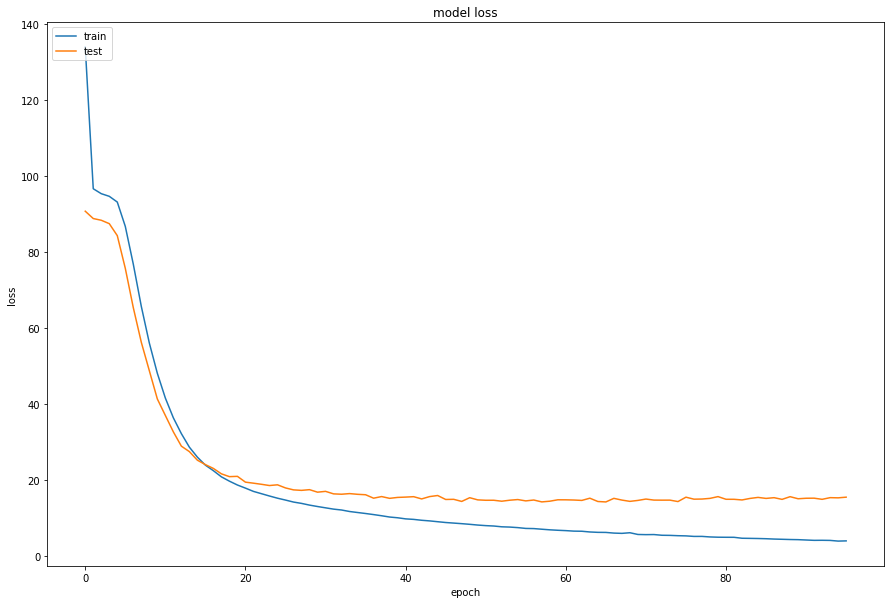

In [33]:
history = online_model.get_history()
fig = plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('online_without_children_NoTimediff_standar_rdg003_resample015_withxy_batch8.png')

In [34]:
def get_evalpreds(eval_seq=None, model=None, extend=False):
    preds = []
    gts = []
    eval_seq = eval_seq
    extend = extend
    length = 3855
    if(extend==True):
        length += 13
    model = model
    for i in range(length):
        f,g,pts = f,g,pts = eval_seq.sample_at_absolute_idx(i)
        gts.append(g)
        out = model.predict(f)
        beam = BeamSearch(25).decode(out,1)
        preds.append(beam[0][0])
    
    return preds, gts

In [35]:
online_preds, online_gts = get_evalpreds(eval_seq=eval_seq, model=online_model,extend=False)

1/1 [==============================] - 2s 2s/step
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 43ms/step


In [36]:
cer = online_model.character_error_rate(online_preds,online_gts)
print("Online Model without children data CER: ", round(cer*100,2))

Online Model without children data CER:  8.13


In [37]:
wer = online_model.word_error_rate(online_preds,online_gts)
print("Online Model without children data WER: ", round(wer*100,2))

Online Model without children data WER:  24.9


In [39]:
def get_children_preds(children_samples=None, model = None):
    model = model
    children_samples = children_samples
    features_children = []
    ground_truth = []
    print(len(children_samples))
    for i in range (len(children_samples)):
        sample = children_samples[i]
        gt = sample.get_groundtruth_text()
        ground_truth.append(gt)
        pts = sample.generate_child_pointSet()
        feature = pts.generate_features()
        features_children.append(feature)
        
    features_c = []
    for i in range (len(features_children)):
        feature_child = features_children[i]
        c = feature_child.shape[0]
        feature_child = np.reshape(feature_child,(1,c,feature_child.shape[1]))
        features_c.append(feature_child)
        
    preds = []
    for i in range (len(features_c)):
        c = features_c[i]
        rnn_out = model.predict(c)
        beam_search_p = BeamSearch(25).decode(rnn_out, 1)
        pred_text = beam_search_p[0][0]
        preds.append(pred_text)

    return preds, ground_truth


In [41]:
path = "./data/children/online"
dir_list = os.listdir(path)
dir_list[:5]

['Vog_1a_pre_ANADYE.csv',
 'Vog_1a_pre_ARBER.csv',
 'Vog_1a_pre_Arianny.csv',
 'Vog_1a_pre_EMIR.csv',
 'Vog_1a_pre_FLORIAN.csv']

In [42]:
children_samples = []
for i in range(len(dir_list)):
    file_path = "./data/children/online/" + dir_list[i]
    gt = file_path.split("/")
    gt = gt[len(gt)-1]
    gt = gt.split(".")
    gt = gt[0]
    gt = gt.split("_")
    gt = gt[len(gt)-1]
    ground_truth = []
    for i in range(len(gt)):
        ground_truth.append(gt[i])
    #ground_truth
    children_samples.append(Each_Sample(file_path,ground_truth))

    #print(ground_truth)
children_samples[:5]

[Vog_1a_pre_ANADYE,
 Vog_1a_pre_ARBER,
 Vog_1a_pre_Arianny,
 Vog_1a_pre_EMIR,
 Vog_1a_pre_FLORIAN]

In [45]:
import pandas as pd
children_pred_last, children_gt_last = get_children_preds(children_samples=children_samples, model=online_model)

53
1/1 [==============================] - 0s 20ms/step


In [49]:
cer = online_model.character_error_rate(children_pred_last,children_gt_last)
print("Online Model without children data CER on Children: ", round(cer*100,2))

Online Model without children data CER on Children:  45.23
